# Different Number of Inputs and Outputs

generates graphs comparing the algorithms ability to maximize mutual information with various numbers of inputs and outputs

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
from google.colab import files

In [0]:
num_players = 2
num_stimuli = 4



num_iterations = 1500
epsilon = .001
inhibition = .333
delta = .001
beta = .5

# response[a][b] is the probability neuron a (where a=0 means x) outputs 1
# when the b stimulus happens (32 values)



In [0]:
#conditional_probability[j][k][x][y] is P(node x = j | node y = k)
def generate_conditional_probabilities_new(response):
  expected_values_1 = stimuli_probability*response
  expected_values_0 = stimuli_probability*(1-response)
  expected_values_by_node_1 = np.sum(expected_values_1,axis=1)
  expected_values_by_node_0 = np.sum(expected_values_0,axis=1)
  average_by_stimuli_1 = np.average(response,axis=0)
  average_by_stimuli_0 = np.average(1-response,axis=0)


  result11 = np.reshape(np.tile(np.sum((expected_values_1.T / expected_values_by_node_1).T * average_by_stimuli_1,axis=1),num_players),(num_players,num_players))
#   print(result11)
  result10 = np.reshape(np.tile(np.sum((expected_values_0.T / expected_values_by_node_0).T * average_by_stimuli_1,axis=1),num_players),(num_players,num_players))
  result01 = np.reshape(np.tile(np.sum((expected_values_1.T / expected_values_by_node_1).T * average_by_stimuli_0,axis=1),num_players),(num_players,num_players))
  result00 = np.reshape(np.tile(np.sum((expected_values_0.T / expected_values_by_node_0).T * average_by_stimuli_0,axis=1),num_players),(num_players,num_players))
#   result11 = np.matmul(stimuli_probability*response, response.T) /(np.dot(response,stimuli_probability))
#     #j = 1, k = 0
#   result10 = np.matmul(stimuli_probability*response, (1-response.T)) /(np.dot(1-response,stimuli_probability))
#   result01 = np.matmul(stimuli_probability*(1-response), response.T) /(np.dot(response,stimuli_probability))
#   result00 = np.matmul(stimuli_probability*(1-response), (1-response.T))/(np.dot(1-response,stimuli_probability))
  
  conditional_probability =  np.array([[result00,result01],[ result10,result11]])
  return conditional_probability
# print(response)
# print()
# print(stimuli_probability)
# print()


def conditional_tester(x,j,y,k):
  sumj = 0
  for j in range(num_stimuli):
    sumj_term = (1-(response[0][j]+response[1][j]+response[2][j]+response[3][j])/4) * (1-response[y][j])*stimuli_probability[j]
    
    suml = 0
    for l in range(num_stimuli):
      suml += (1-response[y][l])*stimuli_probability[l]
    sumj_term /= suml
    sumj += sumj_term
  return sumj
#conditional_probability[j][k][x][y] is P(node x = j | node y = k)
def generate_conditional_probabilities_old(response):
  #j = 1, k = 1
  result11 = np.matmul(stimuli_probability*response, response.T) /(np.dot(response,stimuli_probability))
    #j = 1, k = 0
  result10 = np.matmul(stimuli_probability*response, (1-response.T)) /(np.dot(1-response,stimuli_probability))
  result01 = np.matmul(stimuli_probability*(1-response), response.T) /(np.dot(response,stimuli_probability))
  result00 = np.matmul(stimuli_probability*(1-response), (1-response.T))/(np.dot(1-response,stimuli_probability))
  
  conditional_probability =  np.array([[result00,result01],[ result10,result11]])


  return conditional_probability

![alt text](https://imgur.com/JugyNds.jpg)

In [0]:
# EV_values[x][b][c] is EV(Node x = c | S_b) 
def generate_BTS(conditional_probabilities,response):
  EV_values = np.zeros(shape = (num_players,num_stimuli,2))
  for node in range(num_players):
    for stimuli in range(num_stimuli):

      for output in range(2):
        EV = 0
        if output == 1:
          EV = inhibition*math.log(np.average(response[:,stimuli]))
        else:
          EV = inhibition*math.log(1-np.average(response[:,stimuli]))
 
        for node1 in range(num_players):
          if node == node1:
            continue
          EV = EV - (1-response[node1][stimuli])*math.log(conditional_probabilities[output][0][node][node1]) \
           -response[node1][stimuli]*math.log(conditional_probabilities[output][1][node][node1])

        EV_values[node][stimuli][output] = EV

  return EV_values

![alt text](https://imgur.com/Wz4IFuh.jpg)

In [0]:
#returns updated "response" matrix
def update_response(EV, jitter,response):
  new_responses = np.zeros(shape = ((num_players,num_stimuli)))
  
  for node in range(num_players):
    for stimuli in range(num_stimuli):

      numerator = response[node][stimuli]*math.exp(beta*(EV[node][stimuli][1]-EV[node][stimuli][0]))
      denominator = 1-response[node][stimuli] + response[node][stimuli]*math.exp(beta*(EV[node][stimuli][1]-EV[node][stimuli][0]))
      term = jitter + numerator/denominator
      
      new_responses[node][stimuli] = max(epsilon,min(1-epsilon,term))

  return new_responses


![alt text](https://imgur.com/MMXg7VA.jpg)

In [0]:
def get_mutual_information(response):


  binary_options = list(itertools.product([0, 1], repeat=num_players))
  responses_both = [response,1-response]
  
  total_sum = 0
  for stimuli in range(num_stimuli):
    for options in binary_options:
      Pxy = Pr(responses_both, options, stimuli)*stimuli_probability[stimuli]
      Px = stimuli_probability[stimuli]
      Py = 0
      for stimuli_inner in range(num_stimuli):
        Py += stimuli_probability[stimuli_inner]*Pr(responses_both, options, stimuli_inner)
      total_sum += Pxy*math.log(Pxy/(Px*Py))
  return total_sum

#example: probability that the 4 nodes output [0,1,0,1] given the stimuli of index "stimuli=6"
def Pr(responses_both, options, stimuli):
  sums = 1
  for player in range(num_players):
    sums *= responses_both[options[player]][player][stimuli]
  return sums
# get_mutual_information()

In [0]:
#@title
#====NOT USED=====
#yields same result as code above, but computation follows more closely to the directions
def get_mutual_information_old():
  total_sum = 0

  binary_options = list(itertools.product([0, 1], repeat=num_players))
  responses_both = [response,1-response]
  
  sums = 0
  for stimuli in range(num_stimuli):
    inner_sum = 0
    for option in binary_options:
      pr_value = Pr(responses_both,option,stimuli)
#       print(pr_value*math.log(pr_value))
      inner_sum += pr_value*math.log(pr_value)
#     print(inner_sum)
    sums += inner_sum*stimuli_probability[stimuli]
  
  sums1 = 0
  for option in binary_options:
    inner_sum = 0
    for stimuli in range(num_stimuli):
      inner_sum += Pr(responses_both,option,stimuli)*stimuli_probability[stimuli]
    sums1 -= inner_sum * math.log(inner_sum)
  return sums1+sums
      
def Pr(responses_both, options, stimuli):
  sums = 1
  for player in range(num_players):
    sums *= responses_both[options[player]][player][stimuli]
  return sums

## display bar graph of responses

In [0]:
#@title
def show_graph(response):


  # data to plot

  

  # create plot
  fig, ax = plt.subplots()
  index = np.arange(num_stimuli)
  bar_width = 0.1
  opacity = 0.8
  
  colors = ['r','g','b','c','m','k']
  for i in range(len(response)):
    rects0 = plt.bar(index+bar_width*i, response[i], bar_width,
                     color=colors[i],
                     label='player {}'.format(i))


  plt.xlabel('Stimuli')
  plt.ylabel('Responsiveness')
  plt.ylim(0,1)
  plt.title('Responsiveness to stimuli by node')
  plt.xticks(index + bar_width, ('Stim 1', '2', '3', '4','5','6','7','8'))
  plt.legend()

  
  plt.show()

KeyboardInterrupt: ignored

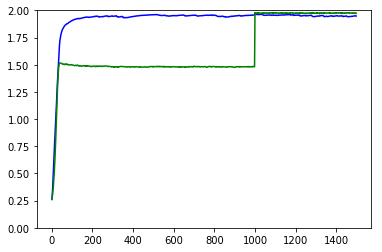

In [9]:

for k in range(10):

  history = {"x":[],"y":[],"y2":[]}

  response_old = np.random.uniform(size=(num_players,num_stimuli))
  response_new = np.copy(response_old)

  # response = np.repeat(np.random.uniform(size=(num_players,1)),num_stimuli, axis=1)

  def softmax(x):
      """Compute softmax values for each sets of scores in x."""
      e_x = np.exp(x - np.max(x))
      return e_x / e_x.sum()
  # stimuli_probability = softmax(np.random.uniform(size=num_stimuli))
  stimuli_probability = np.ones(num_stimuli)/num_stimuli
  for i in range(0,num_iterations):

    conditional_probabilities_old = generate_conditional_probabilities_old(response_old)
    conditional_probabilities_new = generate_conditional_probabilities_new(response_new)


    EV_old = generate_BTS(conditional_probabilities_old,response_old)
    EV_new = generate_BTS(conditional_probabilities_new,response_new)

    response_old = update_response(EV_old,np.random.uniform(low=-delta,high=delta),response_old)
    response_new = update_response(EV_new,np.random.uniform(low=-delta,high=delta),response_new)
    if i == 1000:
      binary_options = list(itertools.product([epsilon, 1-epsilon], repeat=num_players))
      for row in range(num_players):
        for col in range(num_stimuli):
          response_old[row][col] = binary_options[col][row]
          response_new[row][col] = binary_options[col][row]
  #   if i % 500 == 0 and i < 8000:
  #     random_change = np.random.normal(scale=.1,size=(num_players,num_stimuli))
  #     response = np.clip(response + random_change,a_min=epsilon,a_max = 1-epsilon)
    if i % 2 == 0:
      history["x"].append(i)
      val = get_mutual_information(response_old)
      history["y"].append(val/math.log(2))

      val = get_mutual_information(response_new)
      history["y2"].append(val/math.log(2))

  plt.ylim(0,min(math.log(num_stimuli)/math.log(2), num_players))
  plt.plot(history["x"],history["y"], "b")
  plt.plot(history["x"],history["y2"], "g")
  file_name = 'images_play{}_stim{}_{}.jpg'.format(num_players,num_stimuli,k)
  plt.savefig(file_name)

  files.download(file_name)
  plt.clf()




In [0]:
response_old = np.clip(response_old,.05,.95)
show_graph(response_old)
